In [1]:
import pandas as pd
import numpy as np

import latools as la

from IPython.display import HTML

from comparison_tools import helpers, stats_1sample, plots_1sample

%matplotlib inline

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


## Data Collection Parameters


In [2]:
HTML(filename="./Parameter_Tables/iolite_data.html")

## Import Data

In [3]:
# define data format description so it can be imported by latools
dataformat = {'genfromtext_args': {'delimiter': ',',
                                   'skip_header': 15},
              'column_id': {'name_row': 13,
                            'delimiter': ',',
                            'timecolumn': 0,
                            'pattern': '([0-9]{1,3}[A-z]{1,2})'},
              'meta_regex': {0: (['name', 'date'],
                                 '([A-z0-9-]+):([0-9/ :AMP]+);')}
             }

In [4]:
dat = la.analyse('raw_data/iolite_data', internal_standard='43Ca', srm_identifier='NIST610',
                 dataformat=dataformat, names='metadata_names')

Starting analysis using "UCD-AGILENT" configuration:
  225 Data Files Loaded: 15 standards, 210 samples
  Analytes: 11B 24Mg 25Mg 27Al 43Ca 55Mn 57Fe 63Cu 66Zn 88Sr
  Internal Standard: 43Ca


AutoRange: 100%|██████████| 225/225 [00:05<00:00, 39.26it/s]




*****************************************
                 WARNING
*****************************************
Autorange failed for some samples:
  1308H1-27e : 53.1
  1308H1-7a  : 59.5
  1308H1-7e  : 57.0

*** THIS IS NOT NECESSARILY A PROBLEM ***
But please check the plots below to make
sure they look OK. Failures are marked by
dashed vertical red lines.

To examine an autorange failure in more
detail, use the `autorange_plot` method
of the failing data object, e.g.:
dat.data['Sample'].autorange_plot(params)
*****************************************



Applying Calibrations: 100%|██████████| 225/225 [00:06<00:00, 36.42it/s]


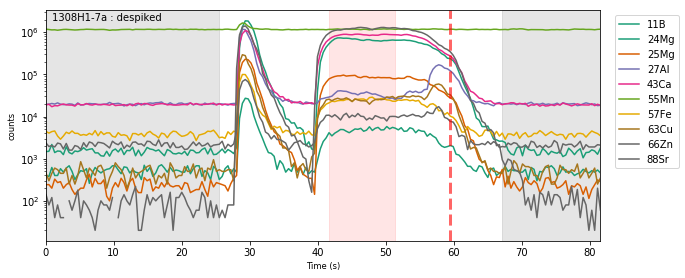

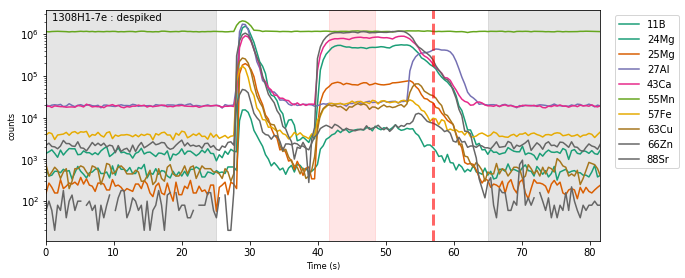

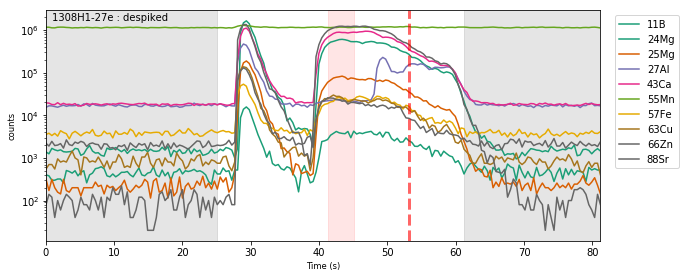

In [5]:
dat.basic_processing(autorange_gwin=5, autorange_swin=3,
                     autorange_win=15, autorange_on_mult=[2, .6],
                     autorange_off_mult=[1, 3], autorange_nbin=5,
                     autorange_transform=None,
                     bkg_weight_fwhm=1000, bkg_filter=True,
                     calib_srms_used=['NIST610'],
                     plots=False)

Plotting backgrounds: 100%|██████████| 10/10 [00:13<00:00,  1.38s/it]


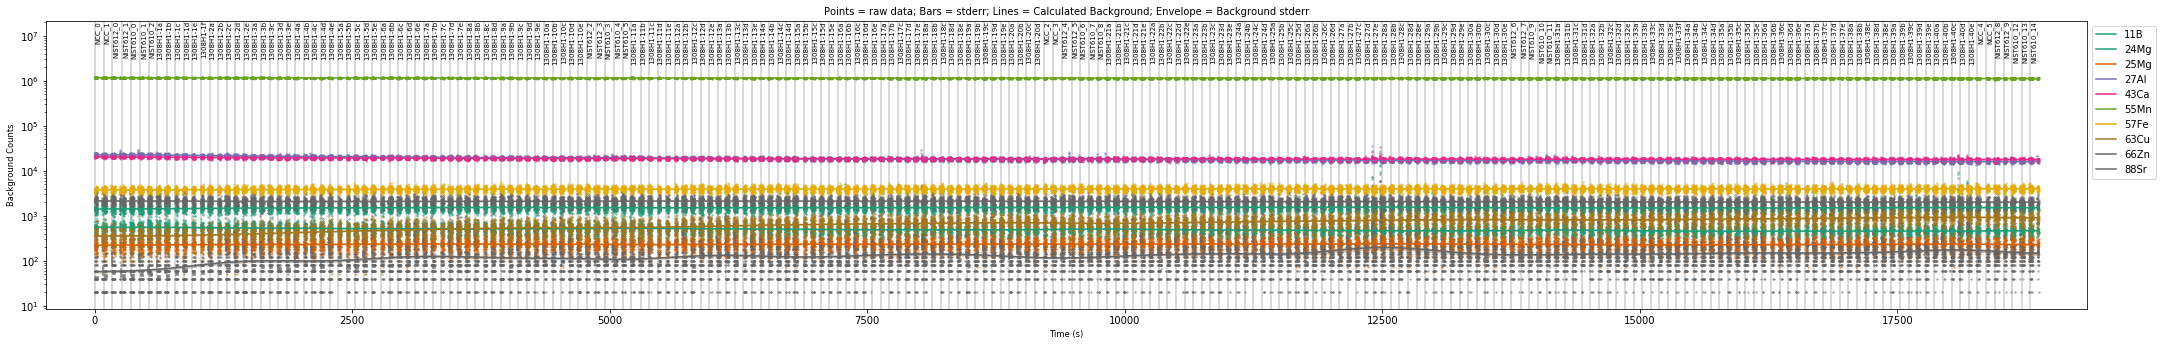

In [6]:
fig, ax = dat.bkg_plot()

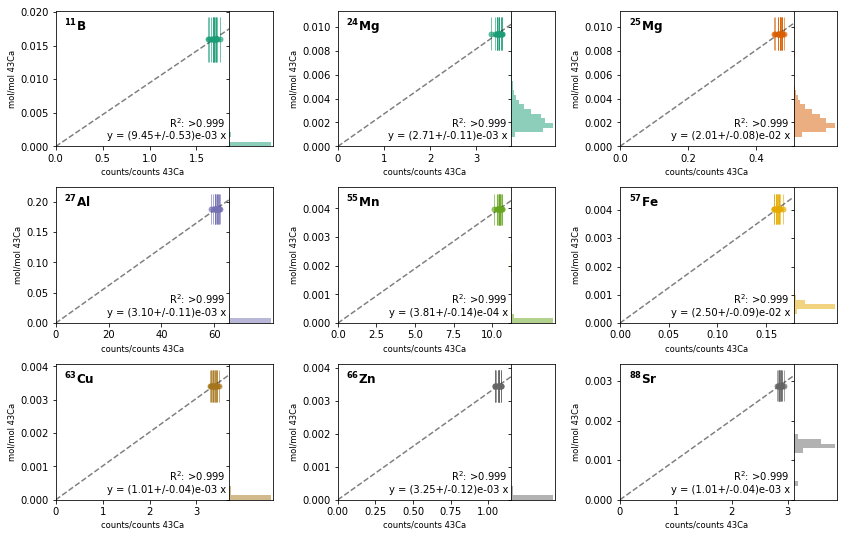

In [7]:
_ = dat.calibration_plot()

### Filtering

In [8]:
dat.filter_clear()

In [9]:
dat.fit_classifier('MnFe', ['55Mn', '57Fe'], 'kmeans', n_clusters=2)
dat.fit_classifier('AlZn', ['27Al', '66Zn'], 'kmeans', n_clusters=2)

'AlZn'

In [10]:
dat.apply_classifier('MnFe')
dat.apply_classifier('AlZn')

Applying AlZn classifier: 100%|██████████| 210/210 [00:00<00:00, 1998.20it/s]


'AlZn'

In [11]:
dat.filter_on('_0', show_status=True)

Subset: All Samples

n  Filter Name  11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  MnFe_0       True   True   True   True   True   True   True   True   True   True   
1  MnFe_1       False  False  False  False  False  False  False  False  False  False  
2  AlZn_0       True   True   True   True   True   True   True   True   True   True   
3  AlZn_1       False  False  False  False  False  False  False  False  False  False  



In [12]:
dat.filter_gradient_threshold_percentile('27Al', [2.5, 97.5], win=5, filt=True)

Percentile theshold filter: 100%|██████████| 210/210 [00:01<00:00, 187.61it/s]


In [13]:
dat.filter_gradient_threshold_percentile('57Fe', [2.5, 97.5], win=5, filt=True)

Percentile theshold filter: 100%|██████████| 210/210 [00:01<00:00, 197.97it/s]


In [14]:
dat.filter_gradient_threshold_percentile('11B', [2.5, 97.5], win=5, filt=True)

Percentile theshold filter: 100%|██████████| 210/210 [00:00<00:00, 213.00it/s]


In [15]:
dat.filter_on('27Al_2.5-95.0-grd-pcnt_inside')
dat.filter_on('57Fe_2.5-95.0-grd-pcnt_inside')
dat.filter_on('11B_2.5-97.5-grd-pcnt_inside', show_status=True)

Subset: All Samples

n  Filter Name                       11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  MnFe_0                            True   True   True   True   True   True   True   True   True   True   
1  MnFe_1                            False  False  False  False  False  False  False  False  False  False  
2  AlZn_0                            True   True   True   True   True   True   True   True   True   True   
3  AlZn_1                            False  False  False  False  False  False  False  False  False  False  
4  27Al_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
5  27Al_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
6  57Fe_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
7  57Fe_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
8  11B_

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 43.15it/s]


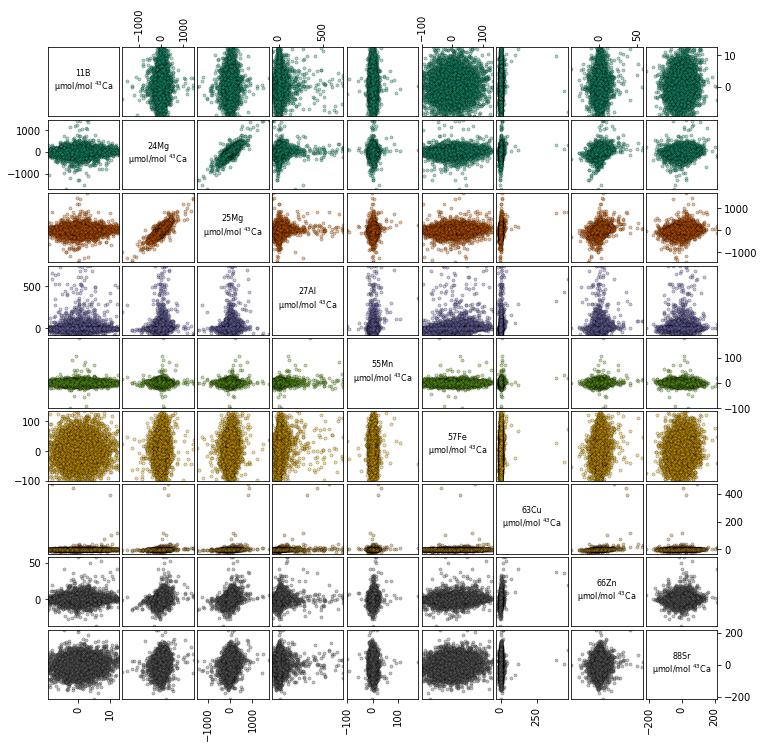

In [16]:
fig, axs = dat.gradient_crossplot(filt=True, mode='scatter', win=5)

Drawing Plots: 100%|██████████| 36/36 [00:00<00:00, 36.03it/s]


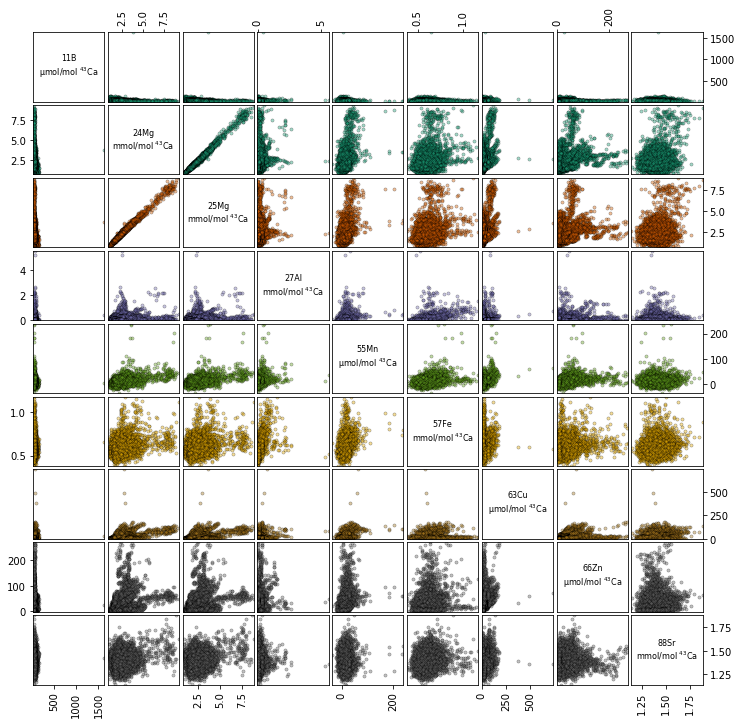

In [17]:
fig, axs = dat.crossplot(filt=True, mode='scatter')

In [18]:
dat.filter_threshold('27Al', 0.5e-3)
dat.filter_threshold('66Zn', 150e-6)
dat.filter_threshold('63Cu', 100e-6)
dat.filter_threshold('55Mn', 90e-6)
dat.filter_threshold('11B', 500e-6)

Threshold Filter: 100%|██████████| 210/210 [00:00<00:00, 6631.51it/s]


In [19]:
dat.filter_on([10, 12, 14, 16, 18], show_status=True)

Subset: All Samples

n  Filter Name                       11B    24Mg   25Mg   27Al   43Ca   55Mn   57Fe   63Cu   66Zn   88Sr   
0  MnFe_0                            True   True   True   True   True   True   True   True   True   True   
1  MnFe_1                            False  False  False  False  False  False  False  False  False  False  
2  AlZn_0                            True   True   True   True   True   True   True   True   True   True   
3  AlZn_1                            False  False  False  False  False  False  False  False  False  False  
4  27Al_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
5  27Al_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
6  57Fe_2.5-97.5-grd-pcnt_inside     True   True   True   True   True   True   True   True   True   True   
7  57Fe_2.5-97.5-grd-pcnt_outside    False  False  False  False  False  False  False  False  False  False  
8  11B_

In [20]:
dat.sample_stats(stats=['H15_mean'])

Calculating Stats: 100%|██████████| 225/225 [00:12<00:00, 18.53it/s]


In [21]:
ld = dat.getstats() * 1e3

### Load Data

In [22]:
import re
import string

In [23]:
# ld = pd.read_csv('Cleaning test/RUN1_export/stat_export.csv', index_col=[0,1,2])
# ld *= 1e3  # convert to mmol/mol
ld = ld.loc['H15_mean', :].dropna().reset_index()

# extract sample and replicate names
mtch = re.compile('([A-Z0-9]+)[_-]([0-9]+)([a-z]?)')\

for i, s in ld['sample'].iteritems():
    gs = mtch.match(s).groups()
    
    if gs[-1] == '':
        r = gs[1]
        s = gs[0]
    else:
        r = string.ascii_lowercase.index(gs[-1])
        s = gs[0] + '_' + gs[1]
    
    ld.loc[i, 'rep'] = r
    ld.loc[i, 'sample'] = s

ld.set_index(['sample', 'rep'], inplace=True)

In [24]:
rd = helpers.load_reference_data('iolite_reference')

In [25]:
df = rd.join(ld)

In [26]:
# no unique samples
np.unique(rd.index.levels[0]).size

89

## Characterise reproducibility in Reference data


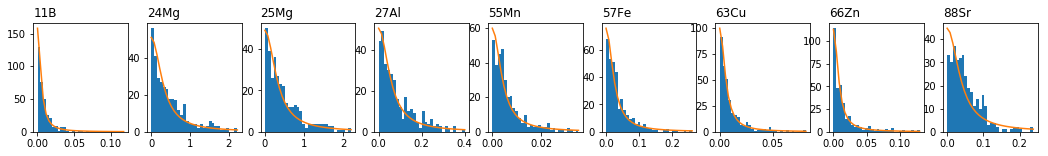

In [27]:
_ = stats_1sample.pairwise_reproducibility(ld, plot=True)

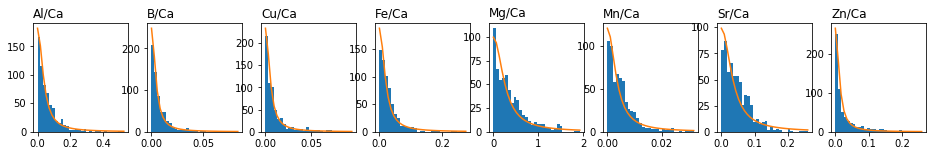

In [28]:
_, rep_dists, rep_stats, _ = stats_1sample.pairwise_reproducibility(rd, plot=True)

In [29]:
rep = pd.DataFrame(rep_stats).T
rep.columns = ['50%', '95%']
rep = rep.reindex(['Mg/Ca', 'Sr/Ca', 'Ba/Ca', 'Al/Ca', 'Mn/Ca', 'Cu/Ca', 'Fe/Ca', 'Zn/Ca', 'B/Ca'])

In [30]:
rep.to_csv('reproducibility_quants.csv')

### Compare

In [31]:
# _ = plots_1sample.comparison_plots(df)

In [32]:
# _ = plots_1sample.residual_plots(df)

In [33]:
from comparison_tools import plots_1sample

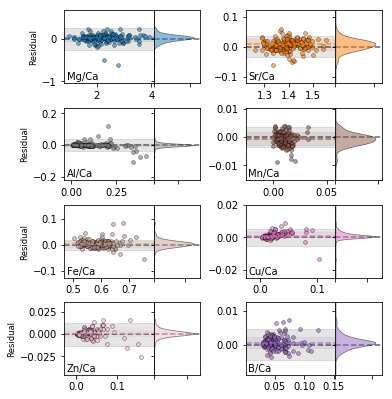

In [34]:
fig, axs = plots_1sample.bland_altman_plots(df, rep_stats)

In [35]:
fig.savefig('Figures/iolite_comparison.pdf')
fig.savefig('Figures/iolite_comparison.png', dpi=200)

## Summary Statistics

In [36]:
stat = stats_1sample.comparison_stats(df)

In [37]:
stat.to_csv('Stats/iolite_stats.csv')